<a href="https://colab.research.google.com/github/JonathanSum/pytorch-Deep-Learning_colab/blob/master/transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
!wget --no-check-certificate \
    https://www.dropbox.com/s/hii00hqj9s1s7m6/Happy%20Sugar%20Life.7z?dl=0 \
    -O /content/data_set.7z

--2020-08-03 11:13:32--  https://www.dropbox.com/s/hii00hqj9s1s7m6/Happy%20Sugar%20Life.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hii00hqj9s1s7m6/Happy%20Sugar%20Life.7z [following]
--2020-08-03 11:13:32--  https://www.dropbox.com/s/raw/hii00hqj9s1s7m6/Happy%20Sugar%20Life.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce4db2fb4e503cc36aaaa9f0e30.dl.dropboxusercontent.com/cd/0/inline/A8zs7XsG5mPMBYl60lmInYfw-5AO10u-IwQinuvkXtKcYI3dc80yGz9hG7Ho82pcKrq51-it6xeKcVzAg5i_3CjPj3eWXWuHUVf51XeF4I7rnsK22Ouc-jXtzasY_duZrns/file# [following]
--2020-08-03 11:13:33--  https://uce4db2fb4e503cc36aaaa9f0e30.dl.dropboxusercontent.com/cd/0/inline/A8zs7XsG5mPMBYl60lmInYfw-5AO10u-IwQinuvkXtKcYI3dc80yGz9hG7Ho82pcKrq51-it6xeK

In [4]:
!p7zip -d "/content/data_set.7z"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 49150094 bytes (47 MiB)

Extracting archive: /content/data_set.7z
--
Path = /content/data_set.7z
Type = 7z
Physical Size = 49150094
Headers Size = 24256
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      5% 133 - Happy Sugar Life/Asahi/Asahi_35 copy.png                                                    12% 374 - Happy Sugar Life/Aunt/Aunt_40 copy.png                                                  18% 498 - Happy Sugar Life/AuntManga/77.png

In [5]:
!mv "Happy Sugar Life" "happy_sugar_life"

In [18]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# # data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# data_dir = '/content/happy_sugar_life'
# tr1 = transforms.Compose([
#         # transforms.RandomResizedCrop(100),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

In [ ]:
# images_data = datasets.ImageFolder(data_dir, tr1)

In [ ]:
# dataloaders_i = torch.utils.data.DataLoader(images_data, batch_size=4,
#                                              shuffle=True)

In [6]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/happy_sugar_life', transform=Compose([Resize((100,100)),ToTensor()]))
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

3104
2328
776
Dataset ImageFolder
    Number of datapoints: 3104
    Root location: /content/happy_sugar_life
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
torch.Size([32, 3, 100, 100]) torch.Size([32])


In [7]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 2328, 'val': 776}

In [8]:
dataset.classes

['Asahi',
 'AsahiManga',
 'Aunt',
 'AuntManga',
 'Kitaumekawa',
 'Mitsuboshi',
 'Satou',
 'SatouManga',
 'SatouShioManga',
 'Shio',
 'ShioManga',
 'Shouko',
 'ShoukoManga']

In [9]:
dataset

Dataset ImageFolder
    Number of datapoints: 3104
    Root location: /content/happy_sugar_life
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [10]:

class_names = dataset.classes

In [11]:
class_names

['Asahi',
 'AsahiManga',
 'Aunt',
 'AuntManga',
 'Kitaumekawa',
 'Mitsuboshi',
 'Satou',
 'SatouManga',
 'SatouShioManga',
 'Shio',
 'ShioManga',
 'Shouko',
 'ShoukoManga']

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



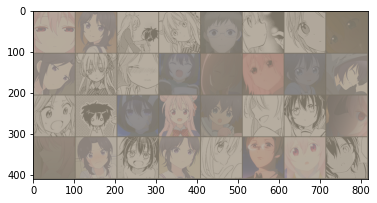

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#title=[class_names[x] for x in classes]
imshow(out, )
title=[class_names[x] for x in classes]
# title

In [ ]:
title

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2790 Acc: 0.6353
val Loss: 0.6032 Acc: 0.8183

Epoch 1/24
----------
train Loss: 0.3913 Acc: 0.8879
val Loss: 0.3861 Acc: 0.8827

Epoch 2/24
----------
train Loss: 0.2026 Acc: 0.9536
val Loss: 0.3112 Acc: 0.9034

Epoch 3/24
----------
train Loss: 0.1195 Acc: 0.9764
val Loss: 0.2800 Acc: 0.9162

Epoch 4/24
----------
train Loss: 0.0650 Acc: 0.9910
val Loss: 0.2572 Acc: 0.9253

Epoch 5/24
----------
train Loss: 0.0523 Acc: 0.9957
val Loss: 0.2521 Acc: 0.9253

Epoch 6/24
----------
train Loss: 0.0312 Acc: 0.9979
val Loss: 0.2520 Acc: 0.9227

Epoch 7/24
----------
train Loss: 0.0262 Acc: 0.9991
val Loss: 0.2519 Acc: 0.9330

Epoch 8/24
----------
train Loss: 0.0278 Acc: 0.9979
val Loss: 0.2565 Acc: 0.9253

Epoch 9/24
----------
train Loss: 0.0239 Acc: 0.9983
val Loss: 0.2505 Acc: 0.9278

Epoch 10/24
----------
train Loss: 0.0233 Acc: 0.9987
val Loss: 0.2489 Acc: 0.9291

Epoch 11/24
----------
train Loss: 0.0240 Acc: 0.9987
val Loss: 0.2477 Acc: 0.9317

Ep

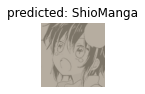

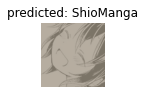

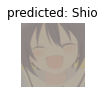

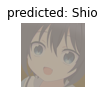

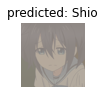

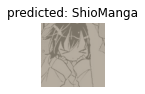

In [24]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
len(dataset.classes)

13

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(dataset.classes))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7872 Acc: 0.4742
val Loss: 1.2491 Acc: 0.6521

Epoch 1/24
----------
train Loss: 1.0742 Acc: 0.7053
val Loss: 0.9892 Acc: 0.7307

Epoch 2/24
----------
train Loss: 0.8743 Acc: 0.7513
val Loss: 0.8832 Acc: 0.7603

Epoch 3/24
----------
train Loss: 0.7573 Acc: 0.7792
val Loss: 0.8040 Acc: 0.7629

Epoch 4/24
----------
train Loss: 0.6861 Acc: 0.7973
val Loss: 0.7608 Acc: 0.7680

Epoch 5/24
----------
train Loss: 0.6445 Acc: 0.8179
val Loss: 0.7269 Acc: 0.7668

Epoch 6/24
----------
train Loss: 0.6078 Acc: 0.8282
val Loss: 0.7080 Acc: 0.7848

Epoch 7/24
----------
train Loss: 0.5569 Acc: 0.8492
val Loss: 0.6998 Acc: 0.7745

Epoch 8/24
----------
train Loss: 0.5696 Acc: 0.8432
val Loss: 0.6939 Acc: 0.7758

Epoch 9/24
----------
train Loss: 0.5655 Acc: 0.8393
val Loss: 0.6942 Acc: 0.7745

Epoch 10/24
----------
train Loss: 0.5396 Acc: 0.8509
val Loss: 0.6794 Acc: 0.7874

Epoch 11/24
----------
train Loss: 0.5552 Acc: 0.8454
val Loss: 0.6819 Acc: 0.7822

Ep

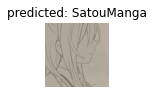

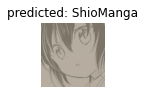

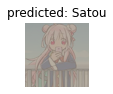

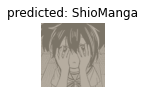

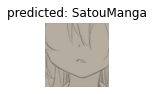

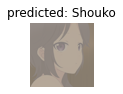

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



